In [1]:
using Random, Distributions, Statistics, DataFrames # w terminalu wpisac julia, potem ] i komenda np. add DataFrames

h = 0.1 #storage cost koszt przechowywania (finansowy proporcjonalny to stop procentowy) 
        #dobry do analizy wrazliwosci
c = 2.0 #unit profit  (marza) 
p = 0.50 #probability of delivery (na 50 za 1 dni 25% za 2 dni  )
K = 40 # fixed order cost kierowca chwcyeneie za telefon 
k = 1.0 # variable order cost liczba przewzoych jednostek 
average_demand = 20 

s = 30 #zmienne decyzycjne  s S je mamy znalezc jesli poziom zapasu spadnie do 30 albo mniej to wtedy dobijamy do 50 
S = 50 

X = 100  # poczatek dnia pierwszego symulacji
profit = 0.0 # ktora kazdnego dnia bedziemy dodawac ( to nie jest parametr zmienna stanu)
# wzgledme ktorych robimy analize wrazliwosci 
# trzeba wybrac na wiecej 2 naraz 
#bedziemy szukac s S ktore generuja najwiekszy profit 

0.0

In [2]:
pois = Distributions.Poisson(average_demand)# mozemy wybrac inny rozklad normalny, log wedlugktorego mozna robic analize wraz
rand(pois, 10) # rozklad poosiona ma mala wariacje (popyt jest bardziej chaotyczny)

10-element Vector{Int64}:
 15
 17
 17
 15
 17
 12
 22
 22
 20
 17

In [3]:
normal=Distributions.Normal(20,5)
sprzedaz = round.(Int, rand(normal, 10))
println(sprzedaz)

[16, 15, 21, 23, 22, 12, 17, 11, 28, 17]


In [4]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.50, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    #pois = Distributions.Poisson(average_demand)
    normal=Distributions.Normal(average_demand,5)
    for day in 1:m
        if Xⱼ < s
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        #demand = rand(pois)
        demand = round.(Int, rand(normal))
        sales = min(Xⱼ, demand) #(stan_magazynu, popyt_w_dniu )
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide  
        @assert lost_order >= 0 
        profit += sales*c - (Xⱼ-sales)*h  # storage costs
        lost_orders += lost_order
        #koszt_jednostkowy_Stock_outu to wtedy bez wag 
        # one_obj = 0.75 * profit + 0.25 * lost_orders * koszt_jednostkowy_Stock_outu 
        # wtedy kiedy wybieramy jedna opcje np logistyke
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels) #,one_obj
end

simulateOneRun (generic function with 1 method)

In [5]:
res = simulateOneRun(20,20,200)

(profit = 602.3, lost_orders = 69.0, warehouse_levels = [100, 84, 59, 38, 200, 180, 158, 134, 118, 107, 88, 70, 53, 36, 23, 0, 0, 0, 200, 181])

In [6]:
@show res.profit
@show res.lost_orders
@show res.warehouse_levels;

res.profit = 602.3
res.lost_orders = 69.0
res.warehouse_levels = [100, 84, 59, 38, 200, 180, 158, 134, 118, 107, 88, 70, 53, 36, 23, 0, 0, 0, 200, 181]


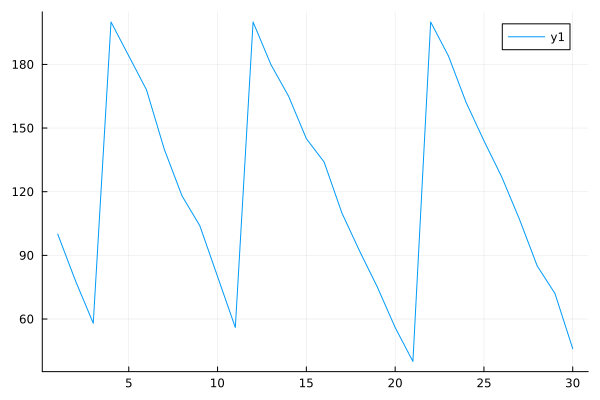

In [7]:
Random.seed!(10)
res = simulateOneRun(30,50,200)

# using PyPlot
# plot(res.warehouse_levels)
# show()
using Plots
plot(res.warehouse_levels)

In [8]:
res = DataFrame(simulateOneRun(9,5,10) for n in 1:4)

Row,profit,lost_orders,warehouse_levels
,Float64,Float64,Array…
1,312.4,61.0,"[100, 81, 68, 44, 29, 10, 0, 0, 0]"
2,180.9,54.0,"[100, 78, 58, 38, 15, 10, 10, 10, 0]"
3,323.5,90.0,"[100, 72, 56, 34, 13, 10, 0, 0, 0]"
4,319.8,61.0,"[100, 74, 59, 39, 30, 10, 0, 10, 0]"


In [9]:

function run_sims(m,s,S,N=100)
    df = DataFrame(simulateOneRun(m,s,S) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end


#run_sims(30,50,100)

run_sims (generic function with 2 methods)

In [10]:
using Random
Random.seed!(0)
df = DataFrame(run_sims(250,s,S,1000)
    for S in 180:5:350, s in 5:5:50 if S > s ) 

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,250,5,180,1000,9391.52,331.781,637.637,126.76
2,250,5,185,1000,9413.35,330.116,627.17,127.088
3,250,5,190,1000,9468.49,327.992,605.217,120.83
4,250,5,195,1000,9488.22,330.005,595.627,123.362
5,250,5,200,1000,9516.57,327.227,582.102,121.781
6,250,5,205,1000,9536.62,313.142,572.135,115.821
7,250,5,210,1000,9560.89,328.941,553.099,120.697
8,250,5,215,1000,9556.5,320.331,549.847,117.835
9,250,5,220,1000,9562.11,312.991,539.899,117.828


In [11]:
best_row = argmin(df.lost_mean)

350

In [12]:
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
350,250,50,350,1000,9260.77,289.952,84.828,64.6009


In [13]:
best_row = argmax(df.profit_mean)

221

In [14]:
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
221,250,35,230,1000,9967.95,293.758,206.157,94.4846


In [15]:
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
221,250,35,230,1000,9967.95,293.758,206.157,94.4846


Zwiekszenie ceny o 5% 
1) podejscie 

In [16]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.50, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20,
    price_increase = 0.05)
    
    # Calculate new price
    new_c = c * (1 + price_increase)
    
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    #pois = Distributions.Poisson(average_demand)
    normal=Distributions.Normal(20,5)
    for day in 1:m
        if Xⱼ < s  # reorder point  #100 < 5 
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        #demand = rand(pois)
        demand = round.(Int, rand(normal))
        sales = min(Xⱼ, demand) #(stan_magazynu, popyt_w_dniu )
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide  
        @assert lost_order >= 0 
        profit += sales*new_c - (Xⱼ-sales)*h  # storage costs
        lost_orders += lost_order
        #koszt_jednostkowy_Stock_outu to wtedy bez wag 
        # one_obj = 0.75 * profit + 0.25 * lost_orders * koszt_jednostkowy_Stock_outu 
        # wtedy kiedy wybieramy jedna opcje np logistyke
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels) #,one_obj
end

simulateOneRun (generic function with 1 method)

In [17]:

function run_sims(m,s,S,N=100)
    df = DataFrame(simulateOneRun(m,s,S,price_increase=0.05) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end


#run_sims(30,50,100)

run_sims (generic function with 2 methods)

In [18]:
using Random
Random.seed!(0)
df = DataFrame(run_sims(250,s,S,1000)
    for S in 180:5:350, s in 5:5:50 if S > s )

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,250,5,180,1000,10264.2,358.547,637.637,126.76
2,250,5,185,1000,10287.6,356.933,627.17,127.088
3,250,5,190,1000,10347.4,353.714,605.217,120.83
4,250,5,195,1000,10369.1,356.029,595.627,123.362
5,250,5,200,1000,10400.5,352.975,582.102,121.781
6,250,5,205,1000,10422.6,337.583,572.135,115.821
7,250,5,210,1000,10449.9,354.982,553.099,120.697
8,250,5,215,1000,10446.1,345.089,549.847,117.835
9,250,5,220,1000,10453.7,337.018,539.899,117.828


In [19]:
best_row = argmax(df.profit_mean)
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
221,250,35,230,1000,10927.1,315.016,206.157,94.4846


In [20]:
# tutaj symulacja zwiekszona o te 5% 

In [21]:
using Random
Random.seed!(0)
df = DataFrame(run_sims(250,s,S,1000)
    for S in 180:5:350, s in 5:5:50 if S > s )

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,250,5,180,1000,10264.2,358.547,637.637,126.76
2,250,5,185,1000,10287.6,356.933,627.17,127.088
3,250,5,190,1000,10347.4,353.714,605.217,120.83
4,250,5,195,1000,10369.1,356.029,595.627,123.362
5,250,5,200,1000,10400.5,352.975,582.102,121.781
6,250,5,205,1000,10422.6,337.583,572.135,115.821
7,250,5,210,1000,10449.9,354.982,553.099,120.697
8,250,5,215,1000,10446.1,345.089,549.847,117.835
9,250,5,220,1000,10453.7,337.018,539.899,117.828


In [22]:
best_row = argmax(df.profit_mean)
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
221,250,35,230,1000,10927.1,315.016,206.157,94.4846


o ile musi zmienić się parametr (np. cena produktu)

In [23]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
function simulateOneRun(pr, m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.50, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    price_increase = pr
    # Calculate new price
    new_c = c * (1 + price_increase)
    
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    #pois = Distributions.Poisson(average_demand)
    normal=Distributions.Normal(20,5)
    for day in 1:m
        if Xⱼ < s  # reorder point  #100 < 5 
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        #demand = rand(pois)
        demand = round.(Int, rand(normal))
        sales = min(Xⱼ, demand) #(stan_magazynu, popyt_w_dniu )
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide  
        @assert lost_order >= 0 
        profit += sales*new_c - (Xⱼ-sales)*h  # storage costs
        lost_orders += lost_order
        #koszt_jednostkowy_Stock_outu to wtedy bez wag 
        # one_obj = 0.75 * profit + 0.25 * lost_orders * koszt_jednostkowy_Stock_outu 
        # wtedy kiedy wybieramy jedna opcje np logistyke
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels) #,one_obj
end

simulateOneRun (generic function with 2 methods)

In [24]:
function run_sims(pr,m,s,S,N=100)
    df = DataFrame(simulateOneRun(pr,m,s,S) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        p=pr,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end

run_sims (generic function with 3 methods)

In [25]:
# wybralem 35,230 to byly najlepsze parametry (najwiekszy profit)
using Random
Random.seed!(0)
df = DataFrame(run_sims(pr,250,35,230,1000)
    for pr in 0.00:0.01:1.0)

Row,m,s,S,N,p,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,250,35,230,1000,0.0,9951.18,287.875,209.203,94.6796
2,250,35,230,1000,0.01,10150.8,294.569,204.686,94.7049
3,250,35,230,1000,0.02,10335.1,291.758,212.174,95.8451
4,250,35,230,1000,0.03,10532.7,312.785,209.304,98.434
5,250,35,230,1000,0.04,10717.0,300.275,210.436,94.4456
6,250,35,230,1000,0.05,10911.4,312.332,209.943,95.8899
7,250,35,230,1000,0.06,11086.4,317.76,211.403,96.7998
8,250,35,230,1000,0.07,11275.1,323.315,212.381,98.4993
9,250,35,230,1000,0.08,11492.7,320.628,205.078,99.5512


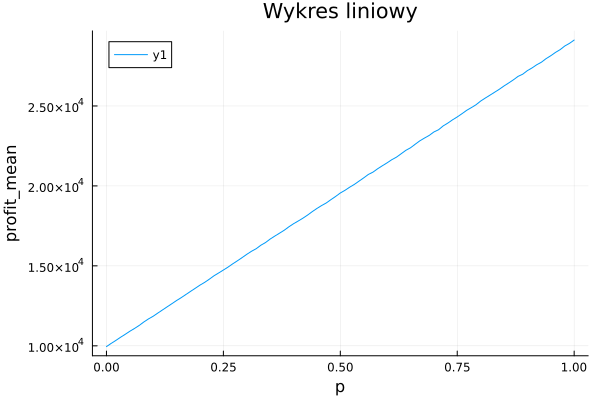

In [26]:
using Plots

plot(df[:, "p"], df[:, "profit_mean"], xlabel="p", ylabel="profit_mean", title="Wykres liniowy")


In [27]:
best_row = argmax(df.profit_mean)
df[best_row,:]

Row,m,s,S,N,p,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
101,250,35,230,1000,1.0,29121.1,745.179,210.381,96.4999


In [28]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.50, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    #pois = Distributions.Poisson(average_demand)
    normal=Distributions.Normal(20,5)
    for day in 1:m
        if Xⱼ < s  # reorder point  #100 < 5 
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        #demand = rand(pois)
        demand = round.(Int, rand(normal))
        sales = min(Xⱼ, demand) #(stan_magazynu, popyt_w_dniu )
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide  
        @assert lost_order >= 0 
        profit += sales*c - (Xⱼ-sales)*h  # storage costs
        lost_orders += lost_order
        #koszt_jednostkowy_Stock_outu to wtedy bez wag 
        # one_obj = 0.75 * profit + 0.25 * lost_orders * koszt_jednostkowy_Stock_outu 
        # wtedy kiedy wybieramy jedna opcje np logistyke
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels) #,one_obj
end

simulateOneRun (generic function with 2 methods)

In [29]:
function run_sims(m,s,S,N)
    df = DataFrame(simulateOneRun(m,s,S) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end

run_sims (generic function with 3 methods)

In [30]:
using Random
Random.seed!(0)
df = DataFrame(run_sims(250,30,250,1000))

LoadError: ArgumentError: 'NamedTuple{(:m, :s, :S, :N, :profit_mean, :profit_std, :lost_mean, :lost_std), Tuple{Int64, Int64, Int64, Int64, Float64, Float64, Float64, Float64}}' iterates 'Int64' values, which doesn't satisfy the Tables.jl `AbstractRow` interface

In [31]:

Random.seed!(0)

# Base simulation
df_base = DataFrame(run_sims(250, 30, 250, 1000))

# # Simulation with 5% increase in unit profit
# df_inc_c = DataFrame(run_sims(250,30,250,1000,c=4.2))

# # Simulation with 5% increase in hourly wage
# df_inc_wage = DataFrame(run_sims(250,30,250,1000,h=0.105))

# # Check R.O. for base simulation
# ro_base = round

LoadError: ArgumentError: 'NamedTuple{(:m, :s, :S, :N, :profit_mean, :profit_std, :lost_mean, :lost_std), Tuple{Int64, Int64, Int64, Int64, Float64, Float64, Float64, Float64}}' iterates 'Int64' values, which doesn't satisfy the Tables.jl `AbstractRow` interface

In [32]:
findall(<=(0), df.profit_mean)


Int64[]

In [33]:
df[66,:]

Row,m,s,S,N,p,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
66,250,35,230,1000,0.65,22382.7,579.939,214.513,97.1942


In [34]:
df[[66, 74,82,90],:]

Row,m,s,S,N,p,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,250,35,230,1000,0.65,22382.7,579.939,214.513,97.1942
2,250,35,230,1000,0.73,23931.3,648.672,212.922,98.323
3,250,35,230,1000,0.81,25494.5,627.214,207.375,96.3676
4,250,35,230,1000,0.89,26986.2,702.371,208.06,98.825


In [35]:
df[findall(<=(-500), df.profit_mean),:]

Row,m,s,S,N,p,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64


In [36]:
more500 = findall(>(-500), df.profit_mean)

101-element Vector{Int64}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
  90
  91
  92
  93
  94
  95
  96
  97
  98
  99
 100
 101

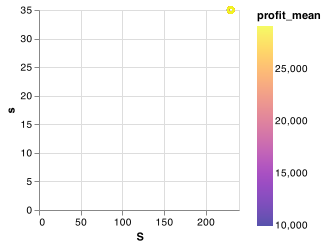

In [37]:
# using PyPlot
# using PyCall 

using VegaLite
df |> @vlplot(:point, x=:S, y=:s, color={:profit_mean, scale={scheme=:plasma}})

# scatter(df.S[more500],
#         df.s[more500], 
#         c=df.profit_mean[more500] )
# xlabel("S - target wharehouse stock ")
# ylabel("s - reorder point")
# colorbar()
# title("Profits")

# scatter(df.S[Not(more500)],
#         df.s[Not(more500)], 
#         c="gray")
# show()

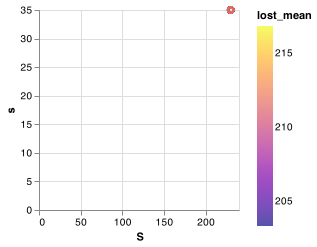

In [38]:
# using PyPlot
# using PyCall 

using VegaLite
df |> @vlplot(:point, x=:S, y=:s, color={:lost_mean, scale={scheme=:plasma}})

        # scatter(df.S[more500],
#         df.s[more500], 
#         c=df.lost_mean[more500] )
# xlabel("S - target wharehouse stock ")
# ylabel("s - reorder point")
# colorbar()
# title("Lost orders")

# scatter(df.S[Not(more500)],
#         df.s[Not(more500)], 
#         c="gray")
# show()
# savefig(raw"c:\temp\lost_orders.png")

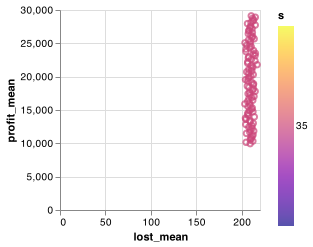

In [39]:
# w zaleznosci od wagi ktora kropka (lewy gorny rog) dla 1 wagi ta blizej lewej
using VegaLite
df |> @vlplot(:point, x=:lost_mean, y=:profit_mean, color={:s, scale={scheme=:plasma}})

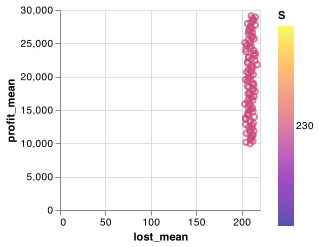

In [40]:
using VegaLite
df |> @vlplot(:point, x=:lost_mean, y=:profit_mean, color={:S, scale={scheme=:plasma}})

In [41]:
using Polynomials
# s_range - przedział wartości dla parametru s
# S_range - przedział wartości dla parametru S
# n_runs - liczba powtórzeń dla każdej kombinacji s i S
function simulateMultiRuns(m, s_range, S_range, n_runs;
    h = 0.1,
    c = 4.0,
    p = 0.50,
    K = 100,
    k = 1.0,
    init_S = 100,
    average_demand = 20)
    
    results = Dict{Tuple{Float64,Float64}, Vector{NamedTuple{(:profit, :lost_orders, :warehouse_levels), Tuple{Float64, Float64, Vector{Int64}}}}}()
    
    for s in s_range
        for S in S_range
            runs = Vector{NamedTuple{(:profit, :lost_orders, :warehouse_levels), Tuple{Float64, Float64, Vector{Int64}}}}(undef, n_runs)
            for i in 1:n_runs
                runs[i] = simulateOneRun(m, s, S; h=h, c=c, p=p, K=K, k=k, init_S=init_S, average_demand=average_demand)
            end
            results[(s,S)] = runs
        end
    end
    
    return results
end

# Funkcja do obliczenia współczynników kierunkowych regresji liniowej dla każdej pary parametrów s i S.
# results - wyniki z funkcji simulateMultiRuns()
function linearRegression(results)
    s_range, S_range = keys(results)
    n_runs = length(results[(s_range, S_range)])
    profits = zeros(length(keys(results)), n_runs)
    
    for (i, (s, S)) in enumerate(keys(results))
        for j in 1:n_runs
            profits[i,j] = results[(s, S)][j].profit
        end
    end
    coeffs = zeros(length(s_range), length(S_range))
    for i in 1:length(s_range)
        coeffs[i,:] = polyfit(S_range, profits[i,:], 1)[1]
    end
    return coeffs
end


LoadError: ArgumentError: Package Polynomials not found in current path.
- Run `import Pkg; Pkg.add("Polynomials")` to install the Polynomials package.

In [42]:
using Polynomials
s_range = 1:10
S_range = 100:110
results = simulateMultiRuns(30, s_range, S_range, 5)
print(results)
# print("---")
# print(keys(results))
# coeffs = linearRegression(results)
# using Plots
# heatmap(S_range, s_range, coeffs', xlabel="S", ylabel="s", title="Współczynniki kierunkowe regresji")


LoadError: ArgumentError: Package Polynomials not found in current path.
- Run `import Pkg; Pkg.add("Polynomials")` to install the Polynomials package.

Przeprowadź Analizę wrażliwości: zmiana parametrów a rozwiązanie optymalne (RO)
– czy zmiana parametru (np.wzrost ceny produktu o 5%/ wzrost wynagrodzenia godzinowego ) spowoduje zmianę R.O., czy ciągle ono pozostanie takie samo? (5+)
